In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../../../Data/Dataset_zero_numeric_missing_v2.csv",sep=";")

In [3]:
data.shape

(11087, 15)

#### drop address and name  because high cardinality

In [4]:
data = data.drop(["address","name"],axis=1)

### Get features categorie

In [5]:
def categorisation(data,date_cols,target="price"):
    distance = []
    date = []
    numerique = []
    categorique = []
    for col in data.columns:
        if data[col].dtypes == np.object:
            try:
                if str(type(eval(data[col][data[col].first_valid_index()]))) == "<class 'list'>":
                    distance.append(col)
                elif col in date_cols:
                    date.append(col)
                else:
                    categorique.append(col)
            except:
                if col in date_cols:
                    date.append(col)
                else:
                    categorique.append(col)
                
            
        else :
            if col != target:
                numerique.append(col)
                
    return dict({"numerique":numerique,"categorique":categorique,"date":date,"distance":distance})

feat_cat = categorisation(data,["Listing Date"])

### target mean ordering encoding of categorical value

In [6]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'price']].groupby(feature).mean()['price']
    #print(frame[[feature, 'a']].groupby(feature).mean()['a'])
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    #print(ordering)
    ordering = ordering['ordering'].to_dict()
    #print(ordering)
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

In [7]:
#tmp = pd.DataFrame({"a":[1,2,5,10],"b":["1","1","o","o"]})

In [8]:
qual_encoded = []
for q in feat_cat["categorique"]:  
    encode(data, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['province_E', 'city_E', 'type_of_property_E']


### Transform distance features

In [9]:
class transfo_distance:
    def __init__(self,data,features=None):
        self.data = data.copy()
        self.method = None
        ### Get features
        self.distance=[]
        if features is None:
            for col in data.columns:
                if data[col].dtypes == np.object:
                    try:
                        if str(type(eval(data[col][data[col].first_valid_index()]))) == "<class 'list'>":
                            self.distance.append(col)
                    except:
                        pass
        else:
            distance=features
        
        ###Transformations : "mean", "median", "max", "min", "len"
    def transformation(self,method):
        self.method = method
        for feat in self.distance:
            serie = []
            for i in self.data[feat]:
                if str(i) != "nan":
                    serie.append(self.checker(i))
                else :
                    serie.append(np.nan)
            self.data[feat] = serie
            
    def checker(self,value):
        if self.method=="mean":
            return (np.array(eval(value))).mean()
        elif self.method =="median":
            return (np.array(eval(value))).mediane()
        elif self.method =="min":
            return (np.array(eval(value))).min()
        elif self.method =="max":
            return (np.array(eval(value))).max()
        elif self.method =="len":
            return float(len(eval(value)))
        else:
            raise('choose correct method : "mean", "median", "max", "min", "len"')
    
    def get_data(self,method="mean"):
        self.transformation(method)
        return self.data
    
trans_dist = transfo_distance(data)
data_len = trans_dist.get_data(method="len")

rename_len = [i+"_len" for i in feat_cat["distance"]]

data[rename_len] = data_len[feat_cat["distance"]]

trans_dist = transfo_distance(data)
data_len = trans_dist.get_data(method="mean")

rename_mean = [i+"_mean" for i in feat_cat["distance"]]

data[rename_mean] = data_len[feat_cat["distance"]]

trans_dist = transfo_distance(data)
data_len = trans_dist.get_data(method="min")

rename_min = [i+"_min" for i in feat_cat["distance"]]

data[rename_min] = data_len[feat_cat["distance"]]

In [10]:
data.shape

(11087, 25)

In [11]:
data[rename_len] = data[rename_len].fillna(0.)
data[rename_mean] = data[rename_mean].fillna(data[rename_mean].median())
data[rename_min] = data[rename_min].fillna(data[rename_min].mean())

In [12]:
data = data.drop(["education",'food_and_entertainment',"transport_and_public_services"],axis=1)

### Check lenght of distances vs price

/home/tokyaxel/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


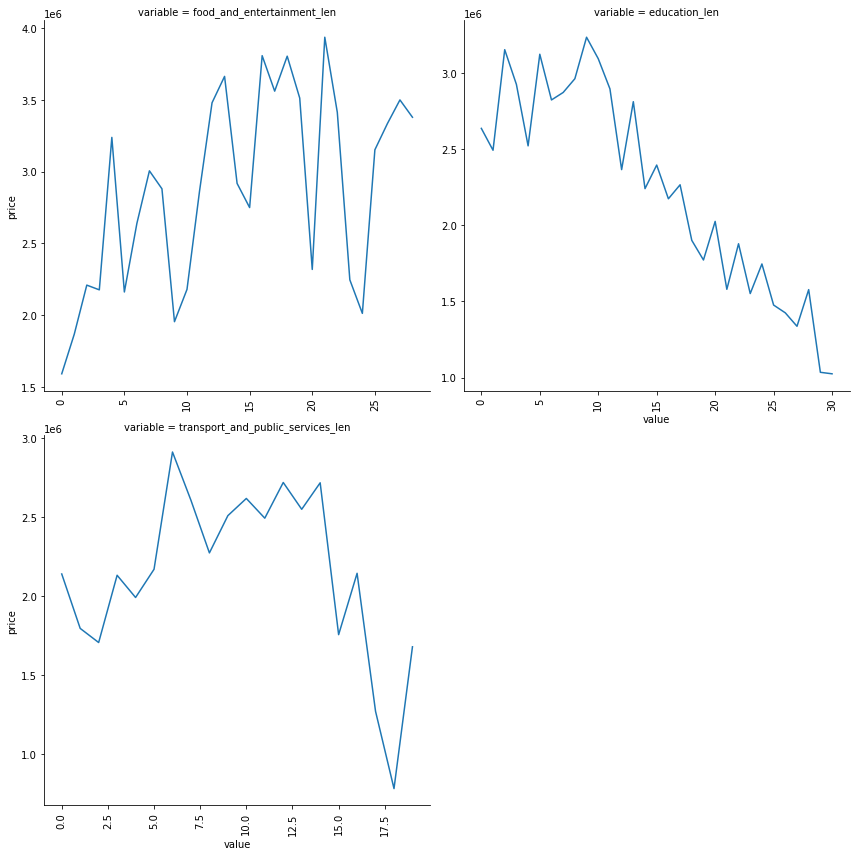

In [13]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
feats = rename_len
f = pd.melt(data, id_vars=['price'], value_vars=feats)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=6)
g = g.map(pairplot, "value", "price")

In [14]:
data[["floor_size", "rates_and_taxes"]] = data[["floor_size", "rates_and_taxes"]].fillna(data[["floor_size", "rates_and_taxes"]].median())

### Sampling

In [15]:
def split_data(data,target,col="sampling",features_to_keep=None):
    if features_to_keep is not None :
        features_to_keep = features_to_keep
        data = data[features_to_keep]
        
    unique = data["sampling"].unique()
    for i, v in enumerate(unique):
        if v == 1 :
            data_train = data[data[col]==v]
            y_train = data_train[target]
            X_train = data_train.drop([target,"sampling"],axis=1)
            print("train shape :",X_train.shape)
        elif v == 2 :
            data_val = data[data[col]==v]
            y_val = data_val[target]
            X_val = data_val.drop([target,"sampling"],axis=1)
            print("val shape :",X_val.shape)
        elif v == 3 :
            data_test = data[data[col]==v]
            y_test = data_test[target]
            X_test = data_test.drop([target,"sampling"],axis=1)
            print("test shape :",X_test.shape)
    
            
    return X_train, np.log(y_train), X_val, np.log(y_val), X_test, np.log(y_test)

In [16]:
data.columns

Index(['Unnamed: 0', 'price', 'province', 'city', 'type_of_property',
       'floor_size', 'bathrooms', 'rates_and_taxes', 'bedrooms', 'sampling',
       'province_E', 'city_E', 'type_of_property_E',
       'food_and_entertainment_len', 'education_len',
       'transport_and_public_services_len', 'food_and_entertainment_mean',
       'education_mean', 'transport_and_public_services_mean',
       'food_and_entertainment_min', 'education_min',
       'transport_and_public_services_min'],
      dtype='object')

In [17]:
feats_to_keep =['price','floor_size', 'bathrooms', 'rates_and_taxes', 'bedrooms', 'sampling',
       'province_E', 'city_E', 'type_of_property_E',
       'food_and_entertainment_len', 'education_len',
       'transport_and_public_services_len', 'food_and_entertainment_mean',
       'education_mean', 'transport_and_public_services_mean',
       'food_and_entertainment_min', 'education_min',
       'transport_and_public_services_min']

In [18]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data,"price",features_to_keep=feats_to_keep)

train shape : (7739, 16)
val shape : (1709, 16)
test shape : (1639, 16)


# Model : Gradient Boosting
https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

In [19]:
params = {'n_estimators': 1000,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.05,
          'loss': 'ls'}

In [20]:
reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, min_samples_split=5,
                          n_estimators=1000)

### RMSE on validation set

In [21]:
rmse = np.sqrt(mean_squared_error(y_val, reg.predict(X_val)))
print("The Root mean squared error (RMSE) onval set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, reg.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

The Root mean squared error (RMSE) onval set: 0.3493
The Root mean squared error (RMSE) on train set: 0.2458


#### feature mportance

In [24]:
labels = X_train.columns

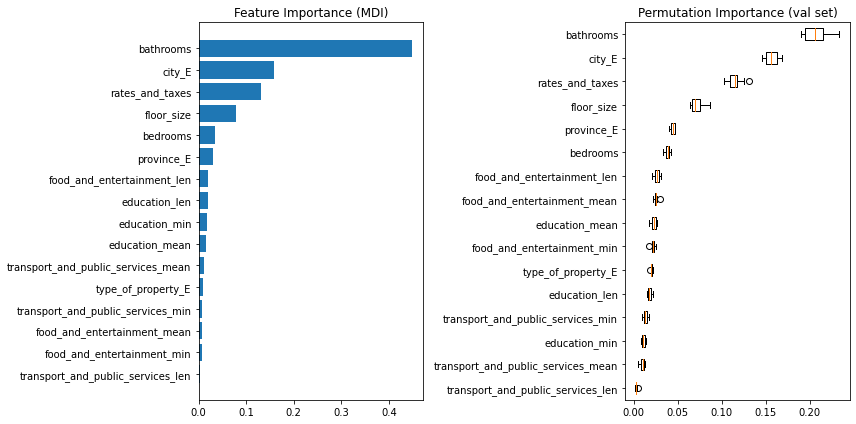

In [25]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(labels)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_val, y_val, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(labels)[sorted_idx])
plt.title("Permutation Importance (val set)")
fig.tight_layout()
plt.show()

### Comparison

In [26]:
print("Model : RF")

RF = RandomForestRegressor()
RF.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_val, RF.predict(X_val)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, RF.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

print("Model : RidgeCV")

regCV = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
regCV.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_val, regCV.predict(X_val)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, regCV.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

print("Model : SVR")

regr = SVR(C=1.0,epsilon=0.2)
regr.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_val, regr.predict(X_val)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, regr.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

Model : RF
The Root mean squared error (RMSE) on val set: 0.3609
The Root mean squared error (RMSE) on train set: 0.1438
Model : RidgeCV
The Root mean squared error (RMSE) on val set: 0.4391
The Root mean squared error (RMSE) on train set: 0.4434
Model : SVR
The Root mean squared error (RMSE) on val set: 0.4853
The Root mean squared error (RMSE) on train set: 0.5023


### Cross validation

In [27]:
X_ = X_val.append(X_train)
y_ = y_val.append(y_train)

In [29]:
scores = cross_validate(reg, X_, y_, scoring='neg_root_mean_squared_error',cv=5, return_train_score=True)
print(scores)

{'fit_time': array([18.6268239 , 18.62809896, 18.66279984, 19.24507475, 19.90038157]), 'score_time': array([0.02618599, 0.02685809, 0.0264852 , 0.02695203, 0.02803707]), 'test_score': array([-0.35146865, -0.35601263, -0.34847054, -0.3423366 , -0.35208448]), 'train_score': array([-0.24171886, -0.23999142, -0.24080754, -0.24480396, -0.24421527])}


### Grid search

In [ ]:
p_test3 = {'learning_rate':[0.005,0.01,0.05,0.1], 'n_estimators':[250,500,750,1000],
          'max_depth':[2,4,6],'min_samples_split': [2,5,7,10]}

tuning = GridSearchCV(estimator =GradientBoostingRegressor(loss='ls'),param_grid = p_test3, scoring='neg_root_mean_squared_error',n_jobs=4, cv=5)
tuning.fit(X_,y_)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

### Evaluate on Test

In [ ]:
params = {'n_estimators': 1000,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.05,
          'loss': 'ls'}

In [ ]:
reg = GradientBoostingRegressor(**params)
reg.fit(X_, y_)

### RMSE on TEST

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))
print("The Root mean squared error (RMSE) on TEST set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, reg.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

### Export model

In [ ]:
import pickle

# save the model to disk
filename = 'GradientBoosting_on_dataset_zero_missing_v1.sav'
pickle.dump(reg, open(filename, 'wb'))